In [21]:
!pip install pafy youtube-dl moviepy

In [23]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [24]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#Dataset

The Dataset we are using is the UCF50 – Action Recognition Dataset.

UCF50 is an action recognition dataset which contains:

50 Action Categories consisting of realistic YouTube videos
25 Groups of Videos per Action Category
133 Average Videos per Action Category
199 Average Number of Frames per Video
320 Average Frames Width per Video
240 Average Frames Height per Video
26 Average Frames Per Seconds per VideoT

In [ ]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2021-10-08 06:51:25--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar            13%[=>                  ] 406.22M  74.0MB/s    in 5.7s    

2021-10-08 06:51:31 (71.3 MB/s) - Connection closed at byte 425950750. Retrying.

--2021-10-08 06:51:32--  (try: 2)  https://www.crcv.ucf.edu/data/UCF50.rar
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 206 Partial Content
Length: 3233554570 (3.0G), 2807603820 (2.6G) remaining [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[++=================>]   3.01G  72.8MB/s    in 40s     

2021-10

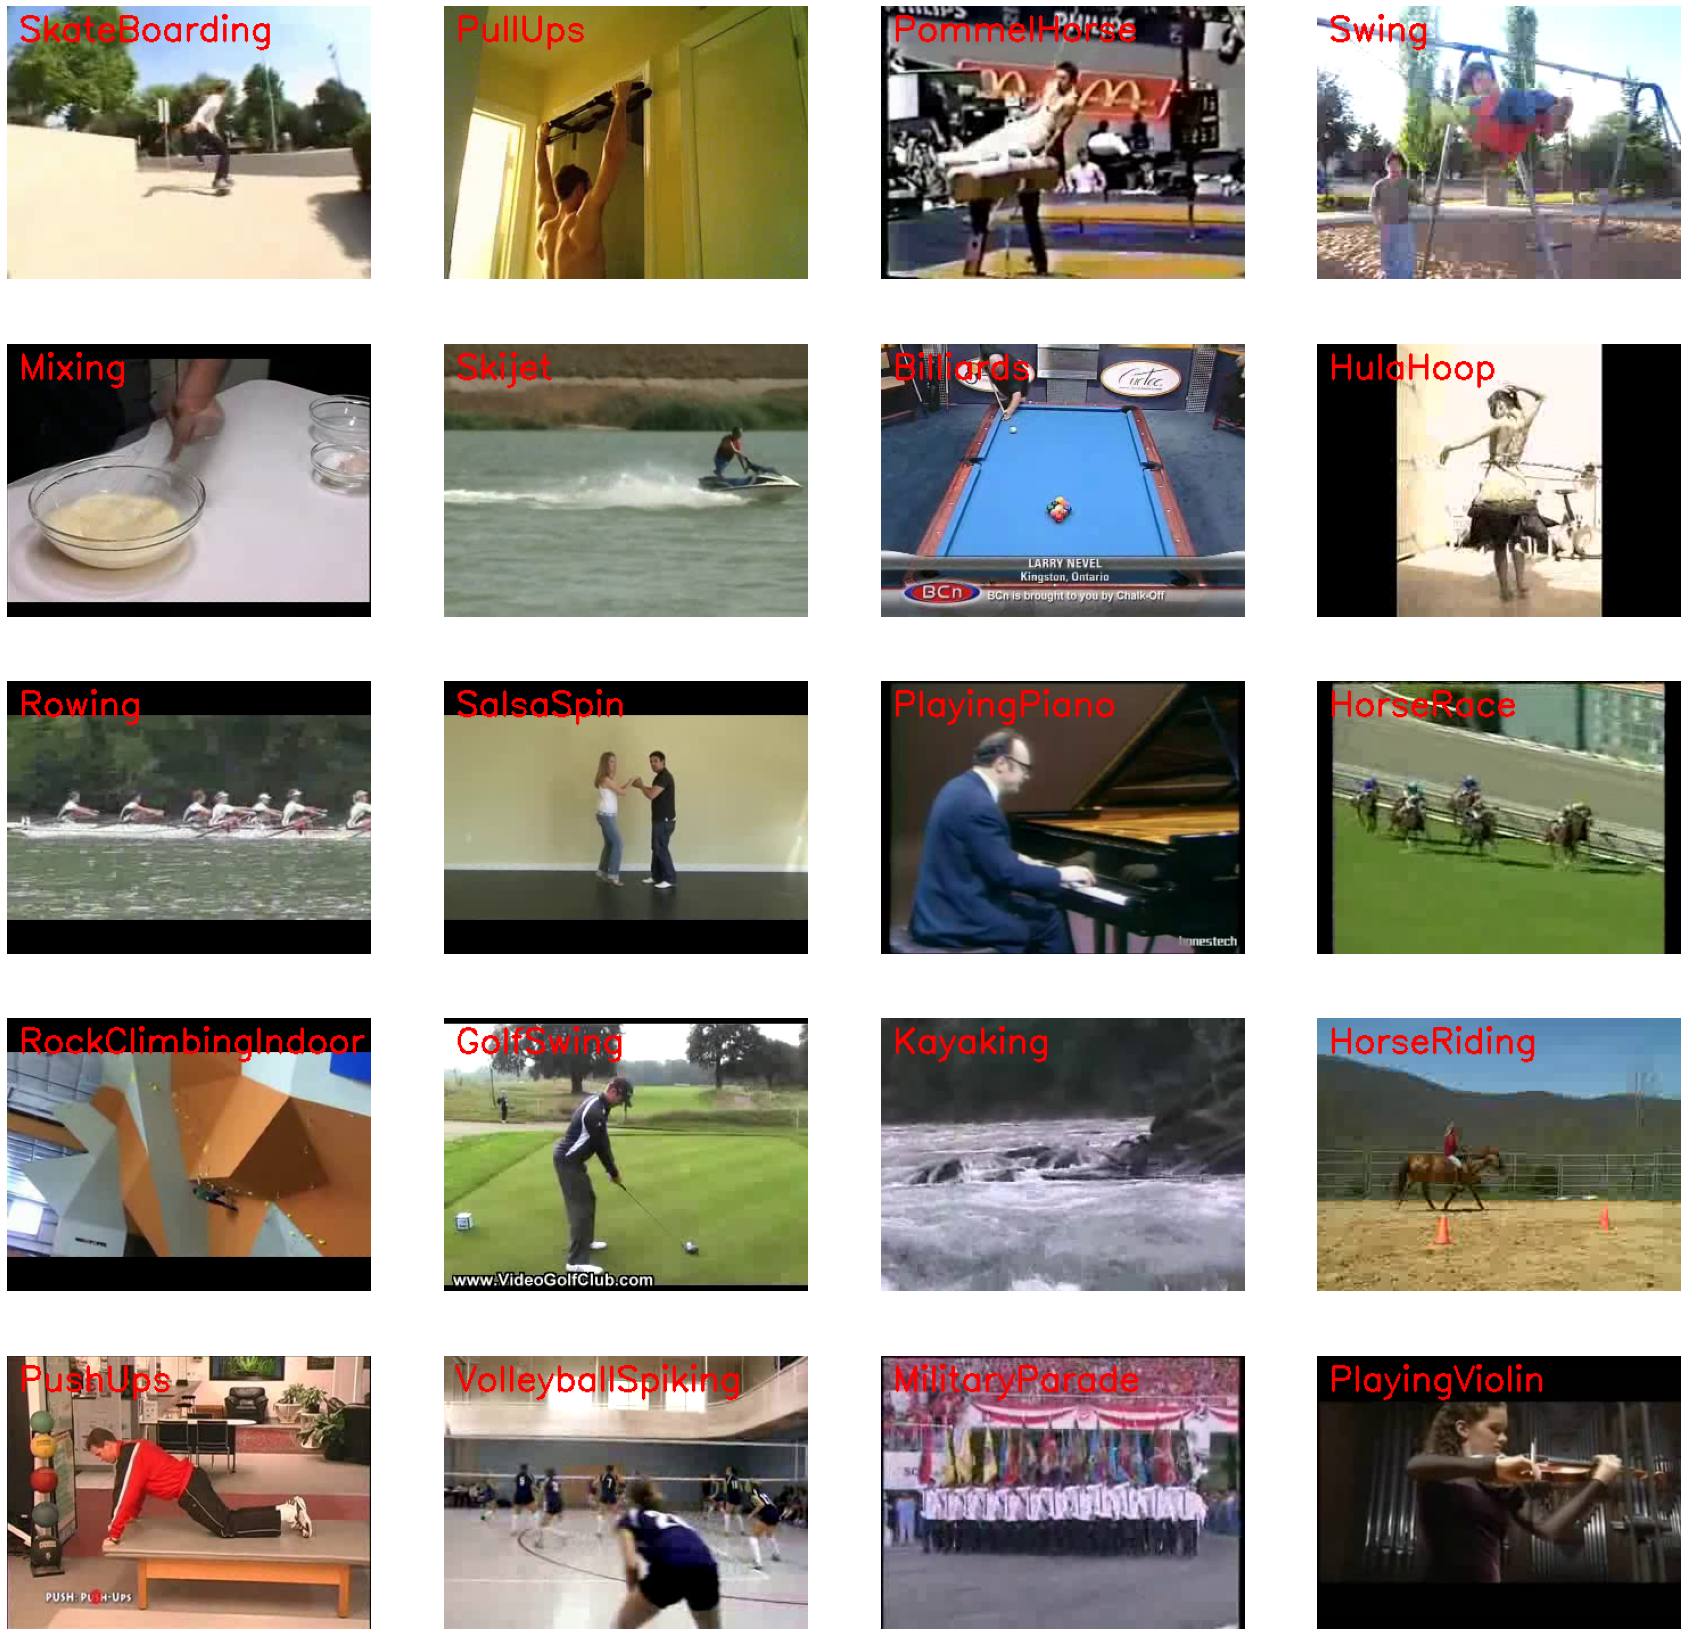

In [25]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

# Read and Preprocess the Dataset



1.   image_height and image_weight: This is the size we will resize all frames of the video to, we are doing this to avoid unnecessary computation
2.   max_images_per_class: Maximum number of training images allowed for each class.
3. dataset_directory: The path of the directory containing the extracted dataset.



In [26]:
#Note: The image_height, image_weight and max_images_per_class constants may be increased
#for better results, but be warned this will become computationally expensive

image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "UCF50"
classes_list = ["Basketball", "WalkingWithDog", "SoccerJuggling", "VolleyballSpiking"]

model_output_size = len(classes_list)

# Extract, Resize and Normalize Frames

Now we will create a function that will extract frames from each video while performing other preprocessing operation like resizing and normalizing images.

This method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list, and then finally returns that list.

In [27]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

# Dataset Creation

Now we will create another function called create_dataset(), this function uses the frame_extraction() function above and creates our final preprocessed dataset.

# Steps



1.   Iterate through all the classes mentioned in the classes_list
2. Now for each class iterate through all the video files present in it.
3. Call the frame_extraction method on each video file.
4. Add the returned frames to a list called temp_features
5. After all videos of a class are processed, randomly select video frames (equal to max_images_per_class) and add them to the list called features.
6. Add labels of the selected videos to the `labels` list.
7. After all videos of all classes are processed then return the features and labels as NumPy arrays.



In [28]:
#So when you call this function, it returns two lists:
#A list of feature vectors
#A list of its associated labels

def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [29]:
features, labels = create_dataset()


Extracting Data of Class: Basketball
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: SoccerJuggling
Extracting Data of Class: VolleyballSpiking


# Step 4: Split the Data into Train and Test Sets

Now we have two numpy arrays, one containing all images. The second one contains all class labels in one hot encoded format. Let us split our data to create a training, and a testing set. We must shuffle the data before the split, which we have already done


In [30]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

# Step 5: Construct a model

Now it is time to create our CNN model, for this post, we are creating a simple CNN Classification model with two CNN layers.

In [ ]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

# Model Structure

Using the plot_model function, we can check the structure of the final model. This is really helpful when we are creating a complex network, and you want to make sure we have constructed the network correctly.

In [ ]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Step 6 Compile and Train the Model

In [33]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
5120/5120 [==============================] - 72s 13ms/step - loss: 1.0301 - accuracy: 0.5655 - val_loss: 1.7129 - val_accuracy: 0.5545
Epoch 2/50
5120/5120 [==============================] - 68s 13ms/step - loss: 0.5759 - accuracy: 0.7845 - val_loss: 0.4359 - val_accuracy: 0.8424
Epoch 3/50
5120/5120 [==============================] - 69s 13ms/step - loss: 0.4191 - accuracy: 0.8493 - val_loss: 0.2729 - val_accuracy: 0.9119
Epoch 4/50
5120/5120 [==============================] - 68s 13ms/step - loss: 0.3387 - accuracy: 0.8817 - val_loss: 0.2372 - val_accuracy: 0.9334
Epoch 5/50
5120/5120 [==============================] - 67s 13ms/step - loss: 0.2945 - accuracy: 0.8982 - val_loss: 0.2053 - val_accuracy: 0.9455
Epoch 6/50
5120/5120 [==============================] - 68s 13ms/step - loss: 0.2583 - accuracy: 0.9102 - val_loss: 0.3144 - val_accuracy: 0.9146
Epoch 7/50
5120/5120 [==============================] - 67s 13ms/step - loss: 0.2428 - accuracy: 0.9187 - val_loss: 0.1354 -

# Save your model

In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)


model_name = f'Model___Date_Time_{current_date_time_string}'

# Saving your Model
model.save(model_name)

INFO:tensorflow:Assets written to: Model___Date_Time_2021_10_08__08_07_44/assets


# Plot Model's LOss and Accuracy Cuvers


In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()
 

In [ ]:
 plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f60e3e78950>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 51, in _cb
    def _cb(arg):
KeyboardInterrupt
Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f60e4cd5290>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 58, in _cb
    callback(self)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 161, in _remove_proxy
    for signal, proxies in list(self._func_cid_map.items()):
KeyboardInterrupt
Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f60db7a9170>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 51, in _cb
    def _cb(arg):
KeyboardInterrupt


In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Step 8 Make Prediction

##### Downloaded Youtube Videos

In [34]:
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title

### Live Videos Using Moving Average

This function will perform predictions on live videos using moving_average. We can either pass in videos saved on disk or use a webcam. If we set window_size hyperparameter to 1, this function will behave like a normal classifier to predict video frames.

Note: You can not use your webcam if you are running this notebook on google colab

In [35]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

## Downloaded A Test Video

In [38]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=l-AevYl_tMI', output_directory)

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [ ]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'
print(output_video_file_path)

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video('/content/Youtube_Videos/WhatsApp Video 2021-09-26 at 1.09.35 PM.mp4', output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)